# Use-case-III: Adversarial Image Detection

Feature attribution for an adversarial sample differs from its benign counterpart because the adversarial perturbation \textit{flips} the model prediction, causing the explanation method to attribute importance to different features. The feature attribution for benign and adversarial images differs. Interestingly, this difference in feature attribution can be measured using simple statistics of dispersion.

In this notebook, we demonstrate the application of explanation methods in detecting adversarial samples for CIFAR-10 dataset. 

We use [quantus](https://quantus.readthedocs.io/en/latest/) for computing feature attribution.

You can download the trained models from [this](https://drive.google.com/drive/folders/1_Az6w5NMkWGyiXpmf0PNJqJdohXMbaiA?usp=sharing) google drive folder. 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
import gc
from captum.attr import *
import quantus

In [1]:
import torchvision
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST as MNISTDataset
import matplotlib
import matplotlib.pyplot as plt
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
import gc
from captum.attr import *
import quantus

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#from rev2.cifar10.data_utils import cifar10_normalize

CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD = [0.2023, 0.1994, 0.2010]


def cifar10_normalize(x, mean=None, std=None):
    if mean is None:
        mean = CIFAR10_MEAN
    if std is None:
        std = CIFAR10_STD
    mu = torch.tensor(mean, device=x.device).view(1, 3, 1, 1)
    st = torch.tensor(std, device=x.device).view(1, 3, 1, 1)
    return (x - mu) / st

# Load model

In [5]:
#from rev2.cifar10.model_utils import resnet50, CIFAR10_RESNET50_CKPT_PATH

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, out_keys=None):
        out = {}
        x = self.conv1(x)
        out["c1"] = x
        x = self.bn1(x)
        out["bn1"] = x
        x = F.relu(x)
        out["r1"] = x

        x = self.layer1(x)
        out["l1"] = x
        x = self.layer2(x)
        out["l2"] = x
        x = self.layer3(x)
        out["l3"] = x
        x = self.layer4(x)
        out["l4"] = x

        x = F.avg_pool2d(x, 4)
        out["gvp"] = x
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        out["fc"] = x

        if out_keys is None:
            return x
        res = {}
        for key in out_keys:
            res[key] = out[key]
        return res


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])


def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])


def resnet50():
    return ResNet(Bottleneck, [3,4,6,3])


def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])


def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

In [6]:
def load_model():
    model = resnet50()
    #ckpt_dict = torch.load(CIFAR10_RESNET50_CKPT_PATH, lambda storage, loc: storage)['net']
    ckpt_dict = torch.load(CIFAR10_RESNET50_CKPT_PATH, lambda storage, loc: storage)
    model.load_state_dict(ckpt_dict)

    #nn.DataParallel(model).load_state_dict(ckpt_dict)
    model.to('cuda')
    model.train(False)
    return model

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(testset, shuffle=True, batch_size=5)

Files already downloaded and verified


In [9]:
CIFAR10_RESNET50_CKPT_PATH = '/data/virtual environments/german_traffic_project/usenix adv2 paper/resnet.ckpt'
normal_model = load_model()

In [10]:
normal_model.to(device)
normal_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

## Making PGD attack

In [11]:
def make_attack(x_batch, y_batch, eps=0.3): 
    
    images_pgd = projected_gradient_descent(normal_model, x_batch, eps, 0.01, 40, np.inf)
    _, y_pred_pgd = normal_model(images_pgd).max(1)
    index = (y_pred_pgd != y_batch)
    pgd_images = images_pgd[index]
    y_pred_pgd = y_pred_pgd[index]
    return pgd_images, y_pred_pgd

# Plot few images and explanations for benign and adv counterpart 

In [12]:
eps = 0.15
x_batch, y_batch = next(iter(test_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

images, labels = x_batch.to(device), y_batch.to(device)
images_pgd, y_pred_pgd = make_attack( images, labels, eps)

In [13]:
gc.collect()
torch.cuda.empty_cache()
a_batch_intgrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())


In [14]:
gc.collect()
torch.cuda.empty_cache()
a_batch_benign = quantus.normalise_func.normalise_by_negative(Saliency(normal_model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())

In [15]:
images_pgd, y_pred_pgd = images_pgd.to(device), y_pred_pgd.to(device)

In [16]:
a_batch_adv_samples = quantus.normalise_func.normalise_by_negative(Saliency(normal_model).attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().numpy())
adv_intgrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=images_pgd, target=y_pred_pgd, baselines=torch.zeros_like(images_pgd)).sum(axis=1).detach().cpu().numpy())

In [30]:
i = 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


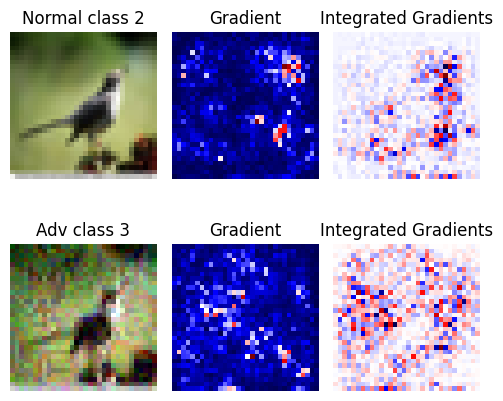

In [31]:
# Plot explanations of normal images!
nr_images = 2
fig, axes = plt.subplots(nrows=nr_images, ncols=3, figsize=(nr_images*2.5, int(nr_images*3)))
images_pgd = images_pgd.cpu()
y_pred_pgd = y_pred_pgd.cpu()
#plot normal
axes[0, 0].imshow((np.moveaxis((x_batch[i].cpu().numpy()), 0, -1)*255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    
axes[0, 0].title.set_text(f"Normal class {y_batch[i].item()}")
axes[0, 0].axis("off")
axes[0, 1].imshow(a_batch_benign[i], cmap="seismic")
axes[0, 1].title.set_text(f"Gradient")
axes[0, 1].axis("off")  
axes[0, 2].imshow(a_batch_intgrad[i], cmap="seismic")
axes[0, 2].title.set_text(f"Integrated Gradients")
axes[0, 2].axis("off")
plt.tight_layout()

#plot adv
axes[1, 0].imshow(np.transpose((images_pgd[i].detach().numpy()),(1,2,0)), cmap="gray")
axes[1, 0].title.set_text(f"Adv class {y_pred_pgd[i].item()}")
axes[1, 0].axis("off")
axes[1, 1].imshow(a_batch_adv_samples[i], cmap="seismic")
axes[1, 1].title.set_text(f"Gradient")
axes[1, 1].axis("off")  
axes[1, 2].imshow(adv_intgrad[i], cmap="seismic")
axes[1, 2].title.set_text(f"Integrated Gradients")
axes[1, 2].axis("off")
plt.tight_layout()

plt.savefig("CIFARAdversarialBenignImageExplanation.pdf", format="pdf", bbox_inches="tight")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


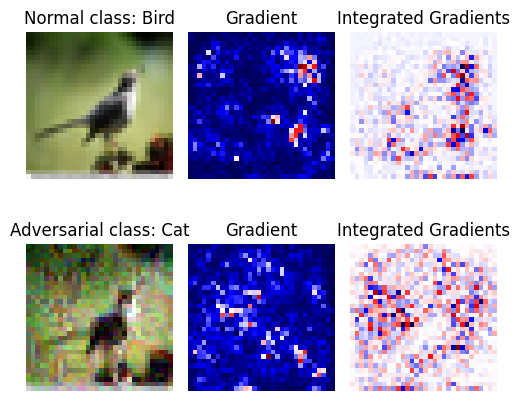

In [33]:
# Plot explanations of normal images!
nr_images = 2
fig, axes = plt.subplots(nrows=nr_images, ncols=3, figsize=(nr_images*2.5, int(nr_images*3)))
images_pgd = images_pgd.cpu()
y_pred_pgd = y_pred_pgd.cpu()
#plot normal
axes[0, 0].imshow((np.moveaxis((x_batch[i].cpu().numpy()), 0, -1)*255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    
axes[0, 0].title.set_text(f"Normal class: Bird")
axes[0, 0].axis("off")
axes[0, 1].imshow(a_batch_benign[i], cmap="seismic")
axes[0, 1].title.set_text(f"Gradient")
axes[0, 1].axis("off")  
axes[0, 2].imshow(a_batch_intgrad[i], cmap="seismic")
axes[0, 2].title.set_text(f"Integrated Gradients")
axes[0, 2].axis("off")
plt.tight_layout()

#plot adv
axes[1, 0].imshow(np.transpose((images_pgd[i].detach().numpy()),(1,2,0)), cmap="gray")
axes[1, 0].title.set_text(f"Adversarial class: Cat")
axes[1, 0].axis("off")
axes[1, 1].imshow(a_batch_adv_samples[i], cmap="seismic")
axes[1, 1].title.set_text(f"Gradient")
axes[1, 1].axis("off")  
axes[1, 2].imshow(adv_intgrad[i], cmap="seismic")
axes[1, 2].title.set_text(f"Integrated Gradients")
axes[1, 2].axis("off")
plt.tight_layout()

plt.savefig("BirdCIFARAdversarialBenignImageExplanation.pdf", format="pdf", bbox_inches="tight")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


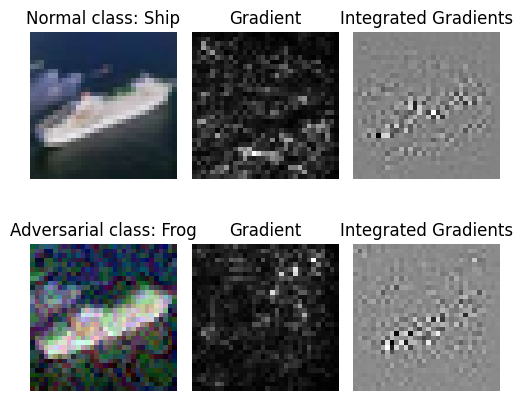

In [20]:
# Plot explanations of normal images!
nr_images = 2
fig, axes = plt.subplots(nrows=nr_images, ncols=3, figsize=(nr_images*2.5, int(nr_images*3)))
images_pgd = images_pgd.cpu()
y_pred_pgd = y_pred_pgd.cpu()
#plot normal
axes[0, 0].imshow((np.moveaxis((x_batch[1].cpu().numpy()), 0, -1)*255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    
axes[0, 0].title.set_text(f"Normal class: Ship")
axes[0, 0].axis("off")
axes[0, 1].imshow(a_batch_benign[1], cmap="gray")
axes[0, 1].title.set_text(f"Gradient")
axes[0, 1].axis("off")  
axes[0, 2].imshow(a_batch_intgrad[1], cmap="gray")
axes[0, 2].title.set_text(f"Integrated Gradients")
axes[0, 2].axis("off")
plt.tight_layout()

#plot adv
axes[1, 0].imshow(np.transpose((images_pgd[1].detach().numpy()),(1,2,0)), cmap="gray")
axes[1, 0].title.set_text(f"Adversarial class: Frog")
axes[1, 0].axis("off")
axes[1, 1].imshow(a_batch_adv_samples[1], cmap="gray")
axes[1, 1].title.set_text(f"Gradient")
axes[1, 1].axis("off")  
axes[1, 2].imshow(adv_intgrad [1], cmap="gray")
axes[1, 2].title.set_text(f"Integrated Gradients")
axes[1, 2].axis("off")
plt.tight_layout()

plt.savefig("GrayCIFARAdversarialBenignImageExplanation.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Standard Statistical measures


- Mean absolute deviation: It is average deviation from mean.
- Median Absolute Deviation: It is median deviation from median.
- Interquartile range: Interquartile range is defined as the difference between the 25th and 75th percentile.  Hence the interquartile range describes the middle 50% of observations. It is not affected by extreme values.

In [26]:
def mean_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        avg = np.mean(a)
        deviation = a - avg 
        absolute_deviation = np.abs(deviation)
        result = np.mean(absolute_deviation)
        scores.append(result)
    return scores    

In [27]:
def median_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        med = np.median(a)
        deviation = a - med 
        abs_deviation = np.abs(deviation)
        result = np.median(abs_deviation)
        scores.append(result)
    return scores 

In [28]:
def iqr(attr):
    #inter-quartile range
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = score_75 - score_25
        scores.append(score_qt)
    return scores
    

# Relative measure of dispersion 

-  A relative measure of dispersion is used to compare the distribution of two or more datasets. A given series of data is accurately exhibited by the absolute measures of dispersion. But one of the major demerits of this is that if there is a need to compare dispersion for a series of different units then it cannot be used. The above-mentioned comparison can be done with relative dispersion.  Another name of relative measures of dispersion is coefficients of dispersion.

In [29]:
#relative measure of dispersion
def coef_var(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        m = np.mean(a)
        st = np.std(attr[i])
        sc = m/st
        scores.append(sc)
    return scores

In [30]:
#relative measure of dispersion

## Coefficient of quartile dev

def coef_iqr(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = (score_75 - score_25)/(score_75 + score_25)
        scores.append(score_qt)
    return scores
    

## Compute statistics

In [31]:

meanAbs_adv =[]
meanAbs_ben = []
medianAbs_adv = []
medianAbs_ben = []

iqr_adv = []
iqr_ben = []

coef_var_adv =[]
coef_var_ben=[]
coef_iqr_adv = []
coef_iqr_ben = []

## Using Saliency attribution method for test images in test_loader. 

In [32]:
for step, (x_batch, y_batch) in enumerate(test_loader):
    if step%20==0:
        print('Step done:', step)
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    images_pgd,y_pred_pgd = make_attack(x_batch, y_batch, eps=0.15)
    
    a_batch_benign = (Saliency(normal_model).attribute(inputs=x_batch, target=y_batch).sum(axis=1).cpu().numpy())
    #a_batch_benign = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())

    images_pgd, y_pred_pgd = images_pgd.to(device), y_pred_pgd.to(device)
    a_batch_adv_samples = (Saliency(normal_model).attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().numpy())
    #a_batch_adv_samples = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=images_pgd, target=y_pred_pgd, baselines=torch.zeros_like(images_pgd)).sum(axis=1).detach().cpu().numpy())
    

    
    meanAbs_adv += mean_abs_dev(a_batch_adv_samples)
    meanAbs_ben += mean_abs_dev(a_batch_benign)
    
    medianAbs_adv += median_abs_dev(a_batch_adv_samples)
    medianAbs_ben += median_abs_dev(a_batch_benign)
    
   
    iqr_adv += iqr(a_batch_adv_samples)
    iqr_ben += iqr(a_batch_benign)
    

    coef_var_adv += coef_var(a_batch_adv_samples)
    coef_var_ben += coef_var(a_batch_benign)
    
    coef_iqr_adv += coef_iqr(a_batch_adv_samples)
    coef_iqr_ben += coef_iqr(a_batch_benign)
  
    if step == 1000:
        break 
    
    

Step done: 0
Step done: 20
Step done: 40
Step done: 60
Step done: 80
Step done: 100
Step done: 120
Step done: 140
Step done: 160
Step done: 180
Step done: 200
Step done: 220
Step done: 240
Step done: 260
Step done: 280
Step done: 300
Step done: 320
Step done: 340
Step done: 360
Step done: 380
Step done: 400
Step done: 420
Step done: 440
Step done: 460
Step done: 480
Step done: 500
Step done: 520
Step done: 540
Step done: 560
Step done: 580
Step done: 600
Step done: 620
Step done: 640
Step done: 660
Step done: 680
Step done: 700
Step done: 720
Step done: 740
Step done: 760
Step done: 780
Step done: 800
Step done: 820
Step done: 840
Step done: 860
Step done: 880
Step done: 900
Step done: 920
Step done: 940
Step done: 960
Step done: 980
Step done: 1000


# Plots

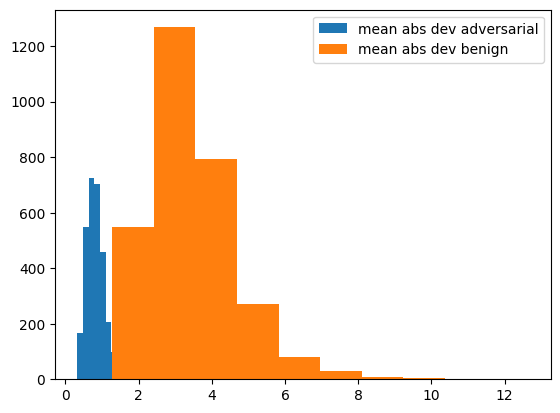

In [34]:
import matplotlib.pyplot as plt 
plt.hist(meanAbs_adv, label="mean abs dev adversarial") 
plt.hist(meanAbs_ben, label="mean abs dev benign")
plt.legend()
#plt.savefig("CIFARStatisticMeanAbsDevPlot.pdf", format="pdf", bbox_inches="tight")
plt.show()

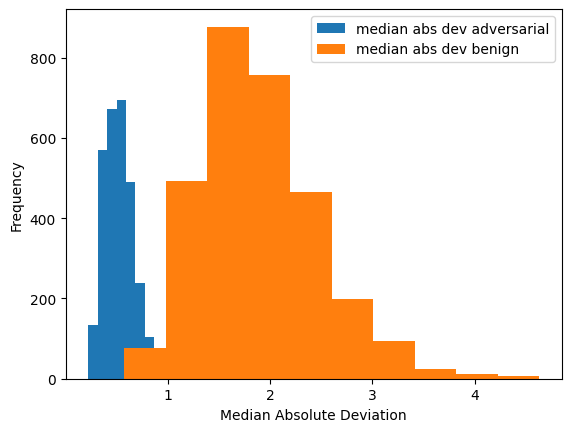

In [35]:
import matplotlib.pyplot as plt 
plt.hist(medianAbs_adv, label="median abs dev adversarial") 
plt.hist(medianAbs_ben, label="median abs dev benign")
plt.xlabel("Median Absolute Deviation")
plt.ylabel("Frequency")
plt.legend()
#plt.savefig("statPlots/CIFARStatisticMedianAbsDevPlot.pdf", format="pdf", bbox_inches="tight")
plt.show()

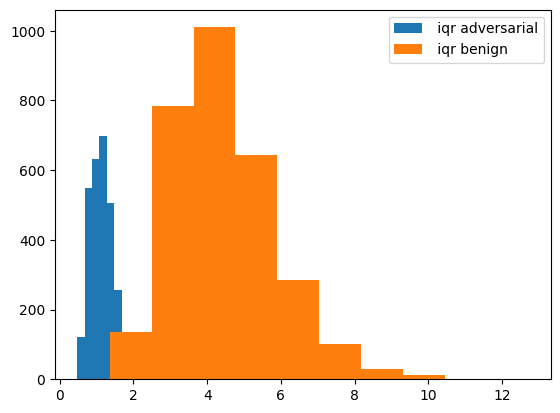

In [36]:
import matplotlib.pyplot as plt 
plt.hist(iqr_adv, label=" iqr adversarial") 
plt.hist(iqr_ben, label=" iqr benign")
plt.legend()
#plt.savefig("CIFARStatisticIQRPlot.pdf", format="pdf", bbox_inches="tight")
plt.show()

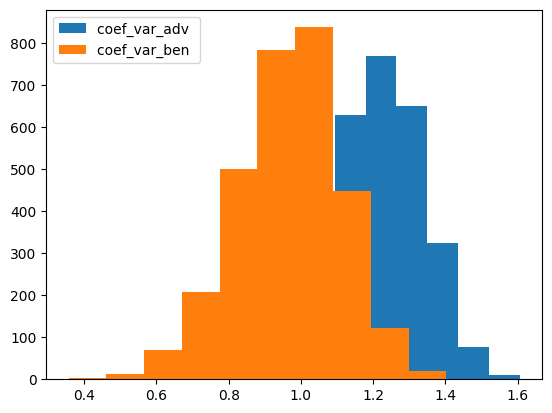

In [37]:
import matplotlib.pyplot as plt 
plt.hist(coef_var_adv, label="coef_var_adv ") 
plt.hist(coef_var_ben, label="coef_var_ben ")
plt.legend()
plt.show()

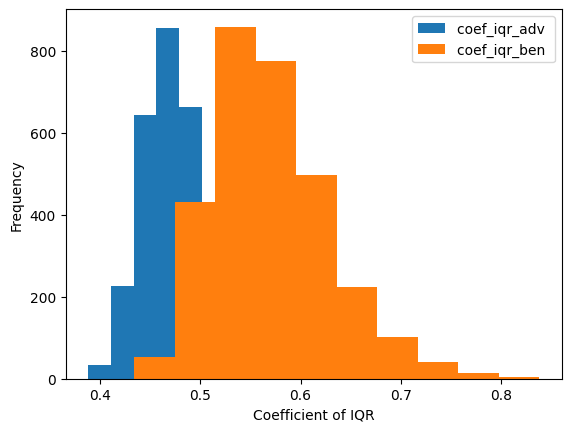

In [38]:

import matplotlib.pyplot as plt 
plt.hist(coef_iqr_adv, label="coef_iqr_adv ") 
plt.hist(coef_iqr_ben, label="coef_iqr_ben ")
plt.xlabel("Coefficient of IQR")
plt.ylabel("Frequency")
plt.legend()
#plt.savefig("statPlots/CIFARCoefIQR.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Create a simple threshold strategy to detect adversarial samples and compute precision and recall of the detection. 

In [39]:
# Threshold to detect adv samples

def compute_precision(TP, FP): 
    return TP/(TP+FP)

def compute_recall(TP, FN):
    return TP/(TP+FN)

In [43]:
#detect adv using coef_iqr

i = 0
j=0

for value in coef_iqr_adv:
    if value <=0.50:
        i=i+1

for value in coef_iqr_ben:
    if value >=0.50:
        j=j+1

print(len(coef_iqr_adv), i, i/len(coef_iqr_adv))
print(len(coef_iqr_ben), j, j/len(coef_iqr_ben))


2957 2390 0.808251606357795
3003 2741 0.9127539127539127


In [44]:
print("precision is:", compute_precision(2390, 3003-2741))
print("recall is:", compute_recall(2741, 2957-2390))

precision is: 0.9012066365007542
recall is: 0.8285973397823458


In [45]:
#use median absolute deviation 
detect = 0
for value in medianAbs_adv:
    if value <=0.75:
        detect=detect+1
print(len(medianAbs_adv), detect, detect/len(medianAbs_adv))


#for benign
i = 0
for value in medianAbs_ben:
    if value >= 0.75:
        i=i+1
print(len(medianAbs_ben), i, i/len(medianAbs_ben))

2957 2749 0.9296584376056815
3003 2993 0.9966699966699967


In [46]:
print("precision is:", compute_precision(2749, 3003-2993))
print("recall is:", compute_recall(2993, 2957-2749))

precision is: 0.9963754983689742
recall is: 0.9350203061543267
